# Финальный проект

Загружаем необходимые библиотеки

In [1]:
# !pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
# os.environ['MKL_NUM_THREADS'] = '1'
# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

Загружаем данные и разбиваем на тренировочные и валидационные.

In [3]:
data = pd.read_csv('./RS_Data/retail_train.csv')
item_features = pd.read_csv('./RS_Data/product.csv')
user_features = pd.read_csv('./RS_Data/hh_demographic.csv')
test = pd.read_csv('./RS_Data/retail_test.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


отбираем топ 5000 популярных, строим матрицу user-items

In [13]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [14]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [16]:
t = 5000
hot_users = data_train_lvl_1['user_id'].unique().tolist()
top_popular = recommender.overall_top_purchases[:t]

In [17]:
%%time

for k in [200, 500, 1000]:
    print(f'Iteration k={k}')
    result_lvl_1[f'als_{k}'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_als_recommendations(x, N=k) if x in hot_users else top_popular)
    print(f'...als finished')
    result_lvl_1[f'own_{k}'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N=k) if x in hot_users else top_popular)
    print(f'...own finished')
    result_lvl_1[f'sim_item_{k}'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_similar_items_recommendation(x, N=k) if x in hot_users else top_popular)
    print(f'...sim_item finished')
    result_lvl_1[f'sim_user_{k}'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_similar_users_recommendation(x, N=k) if x in hot_users else top_popular)
    print(f'...sim_user finished')
result_lvl_1.head(2)

Wall time: 0 ns


,user_id,actual,als_200,own_200,sim_item_200,sim_user_200,als_500,own_500,sim_item_500,sim_user_500,als_1000,own_1000,sim_item_1000,sim_user_1000
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[885290, 909497, 841584, 1047619, 1078543, 920...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 9803545, 9...","[1135983, 5564850, 8293439, 866828, 918598, 10...","[885290, 909497, 841584, 1047619, 1078543, 920...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 9803545, 9...","[1135983, 5564850, 8293439, 866828, 918598, 10...","[885290, 909497, 841584, 1047619, 1078543, 920...","[856942, 9297615, 5577022, 877391, 9655212, 88...","[824758, 1007512, 9297615, 5577022, 9803545, 9...","[1135983, 5564850, 8293439, 866828, 918598, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 916122, 919534, 934399, 844179, 1075...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 819978, 88...","[1054402, 9419422, 855454, 823576, 9392953, 96...","[5569230, 916122, 919534, 934399, 844179, 1075...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 819978, 88...","[1054402, 9419422, 855454, 823576, 9392953, 96...","[5569230, 916122, 919534, 934399, 844179, 1075...","[911974, 1076580, 1103898, 5567582, 1056620, 9...","[8090509, 5569845, 1044078, 985999, 819978, 88...","[1054402, 9419422, 855454, 823576, 9392953, 96..."


In [18]:
%%time

total_result_lvl_1 = pd.DataFrame([{}])
for k in [200, 500, 1000]: 
    print(f'Iteration k={k}')
    total_result_lvl_1[f'als_{k}'] = result_lvl_1.apply(lambda row: recall_at_k(row[f'als_{k}'], row['actual'], k), axis=1).mean()
    total_result_lvl_1[f'own_{k}'] = result_lvl_1.apply(lambda row: recall_at_k(row[f'own_{k}'], row['actual'], k), axis=1).mean()
    total_result_lvl_1[f'sim_user_{k}'] = result_lvl_1.apply(lambda row: recall_at_k(row[f'sim_user_{k}'], row['actual'], k), axis=1).mean()
    total_result_lvl_1[f'sim_item_{k}'] = result_lvl_1.apply(lambda row: recall_at_k(row[f'sim_item_{k}'], row['actual'], k), axis=1).mean()

Iteration k=200
Iteration k=500
Iteration k=1000
Wall time: 3.53 s


In [19]:
total_result_lvl_1

,als_200,own_200,sim_user_200,sim_item_200,als_500,own_500,sim_user_500,sim_item_500,als_1000,own_1000,sim_user_1000,sim_item_1000
0,0.099797,0.135296,0.016021,0.086252,0.149472,0.181904,0.025042,0.136778,0.196592,0.216678,0.033789,0.182214


In [20]:
total_result_lvl_1.T.sort_values(by=0, ascending=False)

,0
own_1000,0.216678
als_1000,0.196592
sim_item_1000,0.182214
own_500,0.181904
als_500,0.149472
sim_item_500,0.136778
own_200,0.135296
als_200,0.099797
sim_item_200,0.086252
sim_user_1000,0.033789


*Лучше себя показала модель own_1000*\
Посмотрим на графике

In [21]:
x_own = total_result_lvl_1[['own_200', 'own_500', 'own_1000']]
x_als = total_result_lvl_1[['als_200', 'als_500', 'als_1000']]
x_sim_item = total_result_lvl_1[['sim_item_200', 'sim_item_500', 'sim_item_1000']]
x_sim_user = total_result_lvl_1[['sim_user_200', 'sim_user_500', 'sim_user_1000']]

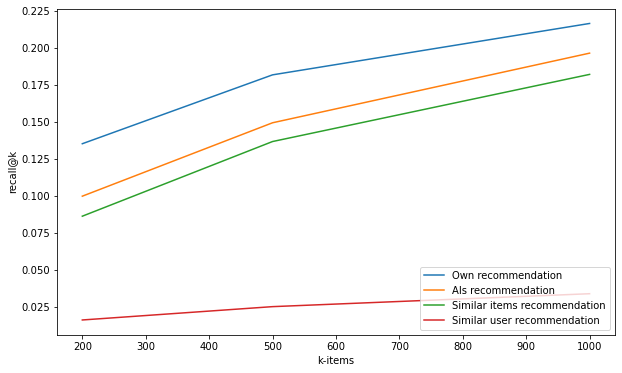

In [22]:
k_list = [200, 500, 1000]

plt.figure(figsize=(10, 6))

plt.plot(k_list, x_own.values[0], label="Own recommendation")
plt.plot(k_list, x_als.values[0], label="Als recommendation")
plt.plot(k_list, x_sim_item.values[0], label="Similar items recommendation")
plt.plot(k_list, x_sim_user.values[0], label="Similar user recommendation")
plt.xlabel('k-items')
plt.ylabel('recall@k')
plt.legend(loc='lower right')
plt.show()

Как видим на графике, лучше всего показала себя модель: Own recommendation, ее и будем использовать для дальнейшего обучения

In [23]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282320,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0
2282321,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0
2282322,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0


In [24]:
data_train_lvl_2.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,169711.000000,1.697110e+05,169711.000000,1.697110e+05,169711.000000,169711.000000,169711.000000,169711.000000,169711.000000,169711.000000,169711.000000,169711.000000
mean,1258.693803,4.091711e+10,614.621303,3.472570e+06,107.986371,3.186085,4152.733677,-0.532118,1541.929940,88.494712,-0.021420,-0.003922
std,720.650823,1.942635e+08,12.064304,4.624471e+06,1212.093885,4.100630,10353.858487,1.260242,395.387438,1.694263,0.268115,0.045033
min,1.000000,4.061849e+10,594.000000,2.811600e+04,0.000000,0.000000,19.000000,-130.020000,0.000000,86.000000,-31.460000,-2.000000
25%,644.000000,4.076472e+10,605.000000,9.237460e+05,1.000000,1.290000,333.000000,-0.690000,1252.000000,87.000000,0.000000,0.000000
50%,1271.000000,4.088877e+10,615.000000,1.038217e+06,1.000000,2.070000,379.000000,-0.100000,1604.000000,89.000000,0.000000,0.000000
75%,1895.000000,4.110961e+10,625.000000,5.568729e+06,1.000000,3.580000,427.000000,0.000000,1829.000000,90.000000,0.000000,0.000000
max,2500.000000,4.129777e+10,635.000000,1.782923e+07,35077.000000,210.000000,34280.000000,0.770000,2359.000000,91.000000,0.000000,0.000000


**фичи для юзер-товар**

In [25]:
data_train_lvl_2['week_day'] = data_train_lvl_2['day'] % 7
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,week_day
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,6
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,6


In [26]:
data_train_lvl_2['quantity_cat'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['quantity'] == 1), 'quantity_cat'] = 1
data_train_lvl_2.loc[((data_train_lvl_2['quantity'] >= 2) & (data_train_lvl_2['quantity'] <= 10 )), 'quantity_cat'] = 2
data_train_lvl_2.loc[(data_train_lvl_2['quantity'] > 10), 'quantity_cat'] = 3
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,week_day,quantity_cat
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,6,1
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,6,1


**фичи для айтема**

In [27]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [28]:
item_features['brand_cat'] = 0
item_features.loc[(item_features['brand'] == 'Private'), 'brand_cat'] = 1

In [29]:
products = ['GROCERY', 'PRODUCE', 'NUTRITION', 'MEAT', 'MEAT-PCKGD', 'DELI', 'PASTRY', 'SEAFOOD-PCKGD', 'SEAFOOD', 
            'RESTAURANT', 'SALAD BAR', 'FROZEN GROCERY', 'CHEF SHOPPE', 'CNTRL/STORE SUP', 'DAIRY DELI', 'DELI/SNACK BAR',
           'GRO BAKERY', 'MEAT-WHSE', 'PORK']
item_features['eat_products'] = 0
item_features.loc[(item_features['department'].isin(products)), 'eat_products'] = 1
item_features.loc[(~item_features['department'].isin(products)), 'eat_products'] = 2
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,brand_cat,eat_products
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0,1
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0,2


In [30]:
item_features['manufactur_cat'] = 0
item_features.loc[(item_features['manufacturer'].value_counts()[:20]), 'manufactur_cat'] = 1
item_features.loc[(item_features['manufacturer'].value_counts()[20:100]), 'manufactur_cat'] = 2
item_features.loc[(item_features['manufacturer'].value_counts()[100:]), 'manufactur_cat'] = 3
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,brand_cat,eat_products,manufactur_cat
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0,1,0
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0,2,3


**фичи для юзера**

In [31]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [32]:
user_features['age_cat'] = 0
user_features.loc[(user_features['age_desc'].isin(['19-24', '25-34'])), 'age_cat'] = 1
user_features.loc[(user_features['age_desc'].isin(['35-44', '45-54'])), 'age_cat'] = 2
user_features.loc[(user_features['age_desc'].isin(['55-64', '65+'])), 'age_cat'] = 3
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_cat
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2


In [33]:
user_features['income_desc'].unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [34]:
salary = ['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '15-24K']

In [35]:
user_features['marital_status_code'].value_counts()

U    344
A    340
B    117
Name: marital_status_code, dtype: int64

In [36]:
user_features['status_cat'] = 0
user_features.loc[((user_features['income_desc'].isin(salary)) & (user_features['marital_status_code'] == 'U')), 'status_cat'] = 1
user_features.loc[((~user_features['income_desc'].isin(salary)) & (user_features['marital_status_code'] == 'U')), 'status_cat'] = 2
user_features.loc[((user_features['income_desc'].isin(salary)) & (user_features['marital_status_code'] == 'A')), 'status_cat'] = 3
user_features.loc[((~user_features['income_desc'].isin(salary)) & (user_features['marital_status_code'] == 'A')), 'status_cat'] = 4
user_features.loc[((user_features['income_desc'].isin(salary)) & (user_features['marital_status_code'] == 'B')), 'status_cat'] = 5
user_features.loc[((~user_features['income_desc'].isin(salary)) & (user_features['marital_status_code'] == 'B')), 'status_cat'] = 6

user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,age_cat,status_cat
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3,3
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2,3


In [37]:
data_train_lvl_2 = data_train_lvl_2.merge(item_features, on='item_id', how='left')
data_train_lvl_2 = data_train_lvl_2.merge(user_features, on='user_id', how='left')
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,manufactur_cat,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,age_cat,status_cat
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,...,0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.0,1.0
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим на пропуски, в случае имеющихся пропусков, заменим их на 0.

In [38]:
data_train_lvl_2.isna().sum()

user_id                     0
basket_id                   0
day                         0
item_id                     0
quantity                    0
sales_value                 0
store_id                    0
retail_disc                 0
trans_time                  0
week_no                     0
coupon_disc                 0
coupon_match_disc           0
week_day                    0
quantity_cat                0
manufacturer                0
department                  0
brand                       0
commodity_desc              0
sub_commodity_desc          0
curr_size_of_product        0
brand_cat                   0
eat_products                0
manufactur_cat              0
age_desc                73701
marital_status_code     73701
income_desc             73701
homeowner_desc          73701
hh_comp_desc            73701
household_size_desc     73701
kid_category_desc       73701
age_cat                 73701
status_cat              73701
dtype: int64

In [39]:
data_train_lvl_2.loc[(data_train_lvl_2['age_desc'].isna()), 'age_desc'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['marital_status_code'].isna()), 'marital_status_code'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['income_desc'].isna()), 'income_desc'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['homeowner_desc'].isna()), 'homeowner_desc'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['hh_comp_desc'].isna()), 'hh_comp_desc'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['household_size_desc'].isna()), 'household_size_desc'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['kid_category_desc'].isna()), 'kid_category_desc'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['age_cat'].isna()), 'age_cat'] = 0
data_train_lvl_2.loc[(data_train_lvl_2['status_cat'].isna()), 'status_cat'] = 0
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,manufactur_cat,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,age_cat,status_cat
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,...,0,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,2.0,1.0
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,...,0,0,0,0,0,0,0,0,0.0,0.0


Построим вторую модель с данными, в которые добавили дополнительные фичи.

In [40]:
n_items_before_2 = data_train_lvl_2['item_id'].nunique()

data_train_lvl_2 = prefilter_items(data_train_lvl_2, item_features=item_features, take_n_popular=5000)

n_items_after_2 = data_train_lvl_2['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before_2, n_items_after_2))

Decreased # items from 27649 to 5001


In [41]:
recommender_2 = MainRecommender(data_train_lvl_2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [51]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [52]:
%%time
k = 5000
hot_users_2 = data_train_lvl_2['user_id'].unique().tolist()
top_popular_2 = recommender_2.overall_top_purchases[:k]
for k in [100, 200, 500, 1000, 1500, 2000, 3000]:
    print(f'iteration: {k}')
    result_lvl_2[f'als_{k}'] = result_lvl_2['user_id'].apply(
        lambda x: recommender_2.get_als_recommendations(x, N=k) if x in hot_users_2 else top_popular_2)
    print('als .... finished')
    result_lvl_2[f'own_{k}'] = result_lvl_2['user_id'].apply(
        lambda x: recommender_2.get_own_recommendations(x, N=k) if x in hot_users_2 else top_popular_2)
    print('own .... finished')


iteration: 100
als .... finished
own .... finished
iteration: 200
als .... finished
own .... finished
iteration: 500
als .... finished
own .... finished
iteration: 1000
als .... finished
own .... finished
iteration: 1500
als .... finished
own .... finished
iteration: 2000
als .... finished
own .... finished
iteration: 3000
als .... finished
own .... finished
Wall time: 54.2 s


In [53]:
%%time

total_result_lvl_2 = pd.DataFrame([{}])
for k in [100, 200, 500, 1000, 1500, 2000, 3000]: 
    print(f'Iteration k={k}')
    total_result_lvl_2[f'als_{k}'] = result_lvl_2.apply(lambda row: recall_at_k(row[f'als_{k}'], row['actual'], k), axis=1).mean()
    total_result_lvl_2[f'own_{k}'] = result_lvl_2.apply(lambda row: recall_at_k(row[f'own_{k}'], row['actual'], k), axis=1).mean()


Iteration k=100
Iteration k=200
Iteration k=500
Iteration k=1000
Iteration k=1500
Iteration k=2000
Iteration k=3000
Wall time: 5.53 s


In [54]:
total_result_lvl_2.T.sort_values(by=0, ascending=False)

,0
own_3000,0.286522
als_3000,0.262436
own_2000,0.253124
own_1500,0.231140
als_2000,0.207154
own_1000,0.205544
als_1500,0.173098
own_500,0.167349
als_1000,0.131511
own_200,0.128096


In [55]:
x_own = total_result_lvl_2[['own_100', 'own_200', 'own_500', 'own_1000', 'own_1500', 'own_2000', 'own_3000']]
x_als = total_result_lvl_2[['als_100', 'als_200', 'als_500', 'als_1000', 'als_1500', 'als_2000', 'als_3000']]

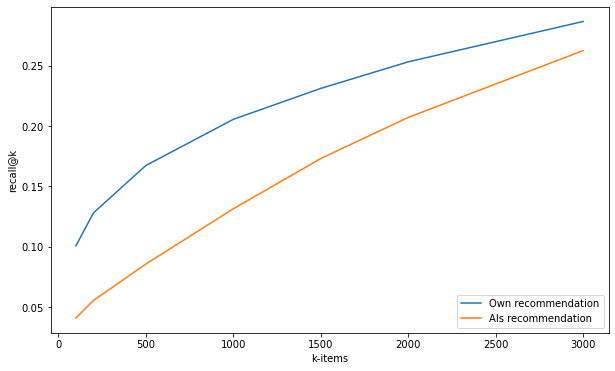

In [56]:
k_list = [100, 200, 500, 1000, 1500, 2000, 3000]

plt.figure(figsize=(10, 6))

plt.plot(k_list, x_own.values[0], label="Own recommendation")
plt.plot(k_list, x_als.values[0], label="Als recommendation")

plt.xlabel('k-items')
plt.ylabel('recall@k')
plt.legend(loc='lower right')
plt.show()

На графике видим, что лучший результат показала модель Own recommendation. Для обучения на тесте будем использовать эту модель.

In [124]:
test = pd.read_csv('./RS_Data/retail_test.csv')

In [125]:
test.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0


In [126]:
test = test.merge(item_features, on='item_id', how='left')
test = test.merge(user_features, on='user_id', how='left')
test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,manufactur_cat,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,age_cat,status_cat
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,...,0,35-44,A,50-74K,Homeowner,2 Adults Kids,5+,3+,2.0,3.0


In [127]:
test.isna().sum()

user_id                     0
basket_id                   0
day                         0
item_id                     0
quantity                    0
sales_value                 0
store_id                    0
retail_disc                 0
trans_time                  0
week_no                     0
coupon_disc                 0
coupon_match_disc           0
manufacturer                0
department                  0
brand                       0
commodity_desc              0
sub_commodity_desc          0
curr_size_of_product        0
brand_cat                   0
eat_products                0
manufactur_cat              0
age_desc                39927
marital_status_code     39927
income_desc             39927
homeowner_desc          39927
hh_comp_desc            39927
household_size_desc     39927
kid_category_desc       39927
age_cat                 39927
status_cat              39927
dtype: int64

In [128]:
test.loc[(test['age_desc'].isna()), 'age_desc'] = 0
test.loc[(test['marital_status_code'].isna()), 'marital_status_code'] = 0
test.loc[(test['income_desc'].isna()), 'income_desc'] = 0
test.loc[(test['homeowner_desc'].isna()), 'homeowner_desc'] = 0
test.loc[(test['hh_comp_desc'].isna()), 'hh_comp_desc'] = 0
test.loc[(test['household_size_desc'].isna()), 'household_size_desc'] = 0
test.loc[(test['kid_category_desc'].isna()), 'kid_category_desc'] = 0
test.loc[(test['age_cat'].isna()), 'age_cat'] = 0
test.loc[(test['status_cat'].isna()), 'status_cat'] = 0
test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,manufactur_cat,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,age_cat,status_cat
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,...,0,0,0,0,0,0,0,0,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,...,0,35-44,A,50-74K,Homeowner,2 Adults Kids,5+,3+,2.0,3.0


In [129]:
n_items_before_test = test['item_id'].nunique()

test = prefilter_items(test, item_features=item_features, take_n_popular=5000)

n_items_after_test = test['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before_test, n_items_after_test))

Decreased # items from 20497 to 5001


In [134]:
# popularity = data_train_lvl_1.groupby('item_id')['quantity'].sum().reset_index()
# popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
# top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
# data_train_lvl_1.loc[~data_train_lvl_1['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,36561,75011,538820,566175,752338,766619,818981,819210,819255,819308,...,18006037,18037791,18055532,18056430,18104617,18105225,18105264,18106229,18119016,18120821
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
recommender = MainRecommender(test)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [137]:
%%time
t = 5000
hot_users_test = test['user_id'].unique().tolist()
top_popular_test = recommender.overall_top_purchases[:t]
for k in [3000]:
    result[f'own_{k}'] = result['user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N=k) if x in hot_users_test else top_popular_test)

Wall time: 468 ms


In [138]:
%%time

total_result = pd.DataFrame([{}])
for k in [3000]: 
    print(f'Iteration k={k}')
#     total_result[f'als_{k}'] = result.apply(lambda row: recall_at_k(row[f'als_{k}'], row['actual'], k), axis=1).mean()
    total_result[f'own_{k}'] = result.apply(lambda row: recall_at_k(row[f'own_{k}'], row['actual'], k), axis=1).mean()


Iteration k=3000
Wall time: 711 ms


In [139]:
total_result

,own_3000
0,0.871676


In [140]:
result

,user_id,actual,own_3000
0,1,"[999999, 883616, 940947, 959219, 991024, 10049...","[959219, 991024, 9527558, 13877012, 1087268, 5..."
1,2,"[999999, 866211, 879769, 885023, 899624, 94094...","[1079659, 879769, 13133971, 7410217, 990656, 1..."
2,3,"[989069, 1130858]","[1130858, 989069, 1029743, 1106523, 1135476, 9..."
3,6,"[847738, 999999, 948650, 1082398, 1100159, 127...","[1100159, 6554077, 12384953, 1036773, 1082398,..."
4,7,"[859987, 863407, 895454, 999999, 930918, 95467...","[12695481, 13112721, 10456186, 1101202, 861246..."
...,...,...,...
1815,2494,"[880427, 894360, 1135006, 1135476, 999999, 823...","[894360, 15716977, 991205, 9831953, 1058345, 6..."
1816,2496,"[829291, 912704, 999999, 992933, 1106523, 5591...","[6553571, 910484, 824796, 13115647, 7441210, 1..."
1817,2498,"[920109, 1004945, 881436, 999999]","[881436, 920109, 1004945, 12264729, 1029743, 1..."
1818,2499,"[895327, 999999, 820321, 829291, 867648, 87899...","[10456164, 883661, 903261, 882308, 9523059, 86..."


Сохраним полученные рекомендации в файл.

In [155]:
PREPARED_TRAIN_DATASET_PATH = './RS_Data/recommendation.csv'

In [169]:
result.to_csv(PREPARED_TRAIN_DATASET_PATH, sep=';', index=False)

In [170]:
submit=pd.read_csv(PREPARED_TRAIN_DATASET_PATH, sep=';')
submit.head()

,user_id,actual,own_3000
0,1,[ 999999 883616 940947 959219 991024 ...,"[959219, 991024, 9527558, 13877012, 1087268, 5..."
1,2,[ 999999 866211 879769 885023 899624 ...,"[1079659, 879769, 13133971, 7410217, 990656, 1..."
2,3,[ 989069 1130858],"[1130858, 989069, 1029743, 1106523, 1135476, 9..."
3,6,[ 847738 999999 948650 1082398 1100159 ...,"[1100159, 6554077, 12384953, 1036773, 1082398,..."
4,7,[ 859987 863407 895454 999999 930918 ...,"[12695481, 13112721, 10456186, 1101202, 861246..."
